In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

from autoencoder import Autoencoder
from solver import test, size_per_epoch, develope_AE, train

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-11-29_00-37-24/


In [4]:
def dev_train_vali_all_epochs(model,size_ls,manner,train_loader,vali_loader,optimizer,n_epochs,device,save_path=None):
	if save_path is None:
		save_path = './'
	else:
		if not os.path.exists(save_path):
			os.makedirs(save_path)
			print('Directory created:', save_path)
	train_losses = []
	all_train_losses = []
	vali_losses = []
	size_each_epoch = size_per_epoch(size_ls,n_epochs,type='step')
	np.save(save_path + 'size_each_epoch.npy',size_each_epoch)
	hyperparam = model.get_hyperparams()

	for epoch in range(n_epochs):
		print(size_each_epoch[epoch])
		model.train()
		# Create new autoencoder with corresponding bottleneck size
		new_n_hidden_ls = np.append(hyperparam['n_hidden_ls'][:-1] , size_each_epoch[epoch])
		if epoch == 0:
			model = Autoencoder(hyperparam['n_input'],new_n_hidden_ls,hyperparam['n_layers'])

		else:
			model = develope_AE(new_n_hidden_ls,hyperparam,save_path=save_path,epoch=epoch,manner=manner)
			optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)
			
		train_loss,train_loss_per_batch = train(model,train_loader,optimizer,epoch,device)
		vali_loss,_,_ = test(model,vali_loader,device)
		train_losses.append(train_loss)
		all_train_losses.append(train_loss_per_batch)
		vali_losses.append(vali_loss)

		# Save the weights of the last epoch.
		torch.save(model.state_dict(), save_path + 'model_weights_epoch{}.pth'.format(epoch))
		print('Weights saved.')

		model.eval()
		latent_list = []

		# Loop through validation data
		with torch.no_grad():  # Gradients not calculated
			for batch_idx, (data, target) in enumerate(test_loader):
				# Convert to a PyTorch variable
				data = Variable(data).to('cpu')

				# Flatten the input data into a 2D tensor [batch_size, num_features]
				batch_size = data.size(0)
				input = data.view(batch_size, -1).to('cpu')

				encoded = model(input)[0]

				latent_list.append(encoded.cpu().numpy())

		latent_matrix = np.concatenate(latent_list)
		print(latent_matrix.shape)
		print(latent_matrix)

		# Perform PCA on number of latent variables available in the bottleneck
		# Max 10 components
		# if size_each_epoch[epoch] < 10:
		# 	pca = PCA(n_components=size_each_epoch[epoch])
		# else:
		# 	pca = PCA(n_components=10)
		pca = PCA(n_components=size_each_epoch[epoch])
		pca.fit(latent_matrix)

		d_explained_variance_ratios.append(pca.explained_variance_ratio_)
		d_latent_matrices.append(pca.components_)

	np.save(save_path + 'all_train_losses.npy',all_train_losses)
	print('All train losses saved.')
	return d_latent_matrices

In [ ]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

# Epoch pairs: [(0, 1), (1, 2), ..., (epochs - 1, epochs)]
all_epoch_pairs = [(i, i + 1) for i in range(n_epochs - 1)]

In [8]:
def pad_latent_matrices(d_latent_matrices, target_dim=32):
    padded_data = []
    for matrices in d_latent_matrices:
        padded_matrices = []
        for matrix in matrices:
            padded_matrix = np.pad(matrix, (0, target_dim - matrix.shape[0]), 'constant')
            padded_matrices.append(padded_matrix)
        while len(padded_matrices) < target_dim:
            padded_matrices.append(np.zeros(padded_matrices[0].shape))
        padded_data.append(padded_matrices)
    return np.array(padded_data)

In [10]:
def angle_between_pcs(padded_data, all_epoch_pairs):
    padded_angle_dict = {}
    for pc in range(size_ls[-1]):
        if pc not in padded_angle_dict:
            padded_angle_dict[pc] = {}
        for epoch_pair in all_epoch_pairs:
            angle = cosine_angle_between_pcs(padded_data[epoch_pair[0]][pc], padded_data[epoch_pair[1]][pc])
            padded_angle_dict[pc][epoch_pair] = angle
    return padded_angle_dict

In [20]:
def plot_heatmap(padded_angle_dict, all_epoch_pairs, k):
    angle_matrix = np.zeros((len(padded_angle_dict), len(all_epoch_pairs)))

    # Fill matrix with angle data
    for pc, epoch_data in padded_angle_dict.items():
        i = 0
        for epoch_pair in all_epoch_pairs:
            angle_matrix[pc, i] = epoch_data[epoch_pair]
            i += 1

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        angle_matrix, 
        annot=True, 
        fmt=".0f",
        norm=LogNorm(), 
        xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
        yticklabels=[f"PC{pc}" for pc in padded_angle_dict.keys()],
        cbar_kws={"label": "Angle between PCs"})
    ax.set_title("Stability of PCs over training epochs (Average of 10 models)")
    plt.savefig(f'Stability_DAE_Plots/Stability_Plot_{k}.png')

In [ ]:
list_of_dictionaries = []

In [ ]:
for k in range(10):
    model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
    device = torch.device('cuda')

    n_epochs = 50
    d_explained_variance_ratios = []
    d_latent_matrices = []

    size_ls = [4, 4, 4, 4, 4, 4, 
           10, 10, 10, 10, 10, 10, 
           16, 16, 16, 16, 16, 16, 
           24, 24, 24, 24, 24, 24, 
           32, 32, 32, 32, 32, 32,
           32, 32, 32, 32, 32, 32, 
           32, 32, 32, 32, 32, 32, 
           32, 32, 32, 32, 32, 32, 
           32, 32]
    manner = 'cell_division'

    dev_train_vali_all_epochs(
        model,
        size_ls,
        manner,
        train_loader,
        test_loader,
        optimizer,
        n_epochs,
        device='cpu',
        save_path=save_path+'Dev/{}/'.format(manner)
        )
    
    padded_data = pad_latent_matrices(d_latent_matrices, 32)
    padded_angle_dict = angle_between_pcs(padded_data, all_epoch_pairs)
    list_of_dictionaries.append(padded_angle_dict)

4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001204: 100%|██████████| 469/469 [00:03<00:00, 135.36it/s]

====> Epoch: 0 Average loss: 0.1222



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1245
Weights saved.
(10000, 4)
[[-0.00735521 -0.10679406 -0.08428451  0.04457687]
 [ 0.07532874 -0.11338308 -0.02452077  0.07159114]
 [-0.01851313 -0.03800999  0.00147334  0.05078008]
 ...
 [-0.06420067 -0.16299282 -0.05239104 -0.01876816]
 [-0.0831484  -0.03663167  0.03132799  0.04113303]
 [ 0.06304553 -0.18921547 -0.02466454  0.00084852]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0602



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0494
Weights saved.
(10000, 4)
[[ 0.02137886 -0.00276975 -0.87574315 -0.21492776]
 [-0.7333609  -0.62259215  0.7726221  -0.52862287]
 [-0.31903234 -0.47451591  0.1288337   0.61465156]
 ...
 [ 0.07442605 -1.0712489  -0.9656776  -0.5784477 ]
 [-0.6852807  -0.78978294 -0.5800776  -0.10181552]
 [-0.425416   -0.5402539  -0.09461427 -1.6563438 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0489



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0485
Weights saved.
(10000, 4)
[[ 0.06786688  0.14706992 -0.8461879  -0.16702878]
 [-0.6861818  -0.6080055   0.8260349  -0.5520468 ]
 [-0.29724786 -0.5015249   0.13680932  0.5896356 ]
 ...
 [ 0.21016693 -1.1032041  -0.95280755 -0.57992697]
 [-0.62956095 -0.79503226 -0.6202744  -0.12272242]
 [-0.45974538 -0.7315029  -0.11419089 -1.8167146 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0484
Weights saved.
(10000, 4)
[[ 0.08811758  0.25399113 -0.8035469  -0.13637187]
 [-0.6886662  -0.60932034  0.8486654  -0.53832674]
 [-0.2923844  -0.5299573   0.1362819   0.5793039 ]
 ...
 [ 0.24781367 -0.9473411  -0.88591564 -0.5371263 ]
 [-0.6085046  -0.7600633  -0.59385586 -0.11408557]
 [-0.47355175 -0.89716303 -0.15158342 -1.8587334 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.0781123   0.356582   -0.78472275 -0.10439976]
 [-0.68651885 -0.587624    0.85212725 -0.52898675]
 [-0.2846807  -0.5424252   0.13699214  0.57016224]
 ...
 [ 0.22362897 -0.73008823 -0.8432976  -0.47620404]
 [-0.6120972  -0.6941664  -0.58031183 -0.09368585]
 [-0.4438578  -1.0034194  -0.16384563 -1.894549  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0484



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.05759523  0.4297409  -0.77487445 -0.06634121]
 [-0.6903052  -0.55517143  0.85672426 -0.5137344 ]
 [-0.27349758 -0.5491949   0.14381373  0.56072277]
 ...
 [ 0.15725987 -0.5102061  -0.82138115 -0.3839079 ]
 [-0.62680733 -0.61782956 -0.57627606 -0.05779503]
 [-0.4145281  -1.0333898  -0.16303574 -1.9182736 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0481
Weights saved.
(10000, 4)
[[ 0.03998997  0.47270045 -0.77122116 -0.04339689]
 [-0.69868034 -0.514884    0.85735536 -0.49446893]
 [-0.26320934 -0.54992616  0.14729077  0.55683297]
 ...
 [ 0.06923102 -0.32543084 -0.8405694  -0.29450774]
 [-0.6546791  -0.54918754 -0.5784934  -0.02288364]
 [-0.4090325  -1.0257676  -0.16243573 -1.91071   ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0483


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.0329961   0.49666038 -0.777915   -0.02177462]
 [-0.713826   -0.48231968  0.8516811  -0.46972746]
 [-0.26088524 -0.5496003   0.15113169  0.5606218 ]
 ...
 [-0.01322494 -0.16166113 -0.85399246 -0.22776088]
 [-0.6821465  -0.4985319  -0.5860311   0.00334398]
 [-0.42367083 -0.9997355  -0.16669302 -1.8861876 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0478
Weights saved.
(10000, 10)
[[ 0.01293709  0.27791435 -0.48130628 ...  0.04983477  0.0182664
   0.06763878]
 [-0.43854052 -0.29118097  0.48382667 ... -0.20854072  0.02697368
   0.06103591]
 [-0.14393795 -0.35494715  0.08016744 ...  0.4074355   0.04409314
   0.04834017]
 ...
 [-0.05843209 -0.052481   -0.5503637  ... -0.02855045 -0.12614581
   0.06925754]
 [-0.41682887 -0.3051647  -0.37494677 ...  0.0700541   0.00244276
   0.05996769]
 [-0.27963865 -0.60614264 -0.12176455 ... -1.1082366  -0.05355594
   0.04226351]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0461


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0438
Weights saved.
(10000, 10)
[[ 3.3669230e-03  2.8474602e-01 -4.9117243e-01 ...  6.4267799e-02
   2.2581816e-02  1.3906892e-01]
 [-4.0759602e-01 -2.8079477e-01  4.8903748e-01 ... -1.5359387e-01
  -2.0912689e-01  3.4885055e-01]
 [-1.6088526e-01 -3.4618413e-01  6.7295454e-02 ...  3.9628470e-01
   8.4095240e-02  3.6768988e-04]
 ...
 [ 2.1079045e-02 -2.7571473e-02 -5.1867563e-01 ...  7.1526051e-02
  -1.0096864e+00  1.6341712e-01]
 [-3.9744714e-01 -2.9062673e-01 -3.6827943e-01 ...  1.1864129e-01
  -2.4372530e-01  2.5524771e-01]
 [-2.4629879e-01 -5.9084910e-01 -1.2446276e-01 ... -1.0550249e+00
  -3.5775459e-01  2.7526072e-01]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0427



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[ 9.77670774e-04  2.90273607e-01 -4.91690248e-01 ...  5.73791862e-02
  -3.04076076e-03 -7.76565168e-04]
 [-3.99548650e-01 -2.67857492e-01  4.88007784e-01 ... -1.22008786e-01
  -1.78275079e-01  5.68713307e-01]
 [-1.59462392e-01 -3.42815518e-01  7.03634620e-02 ...  4.01338607e-01
   7.09320456e-02 -6.30017072e-02]
 ...
 [ 2.14240570e-02 -3.26330885e-02 -5.16999304e-01 ...  6.78240806e-02
  -1.11402714e+00 -8.19406137e-02]
 [-3.91217113e-01 -2.91179121e-01 -3.65178466e-01 ...  1.38820589e-01
  -2.20143646e-01  3.61419499e-01]
 [-2.36418024e-01 -5.87228298e-01 -1.21495619e-01 ... -1.00533700e+00
  -2.87231475e-01  6.01047516e-01]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.00135906  0.29169482 -0.49690884 ...  0.06184106 -0.03101888
  -0.12088938]
 [-0.39901614 -0.27393216  0.48119253 ... -0.11215848 -0.19283766
   0.5245027 ]
 [-0.15849492 -0.34271446  0.06955769 ...  0.4053954   0.07010537
  -0.07990811]
 ...
 [ 0.02665339 -0.0299118  -0.51619935 ...  0.07219233 -1.1127822
  -0.09989338]
 [-0.3900054  -0.29824445 -0.36984852 ...  0.14634828 -0.22083348
   0.3277536 ]
 [-0.23772033 -0.57942706 -0.11771511 ... -0.98683226 -0.26922727
   0.6337955 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.00421764  0.28730536 -0.49894312 ...  0.06660124 -0.04121292
  -0.17763714]
 [-0.40672457 -0.27093446  0.46950895 ... -0.1027977  -0.20324254
   0.48809323]
 [-0.16083546 -0.34182262  0.06476843 ...  0.41204762  0.06706592
  -0.08951557]
 ...
 [ 0.02951738 -0.02830719 -0.51647943 ...  0.08247431 -1.1170626
  -0.09975447]
 [-0.3938318  -0.29475737 -0.3737998  ...  0.15210488 -0.22516298
   0.30445167]
 [-0.24086444 -0.5741061  -0.12479676 ... -0.9705394  -0.26757354
   0.6313681 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0420



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 10)
[[-0.00671958  0.2933745  -0.5081842  ...  0.08460581 -0.04675895
  -0.20157522]
 [-0.4143385  -0.26777065  0.46029067 ... -0.07850742 -0.2060566
   0.4745975 ]
 [-0.1673535  -0.34028587  0.05607395 ...  0.4218709   0.06718755
  -0.09631599]
 ...
 [ 0.02951183 -0.02342959 -0.5202838  ...  0.09113363 -1.1144345
  -0.10076628]
 [-0.3984279  -0.29465264 -0.378189   ...  0.1704427  -0.22022188
   0.30247307]
 [-0.24389322 -0.5721943  -0.14008875 ... -0.9504844  -0.26074344
   0.62591213]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0420


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 10)
[[-0.02304227  0.2975679  -0.5322197  ...  0.11308062 -0.04325819
  -0.21183832]
 [-0.43317407 -0.25438553  0.4278774  ... -0.04786614 -0.20306873
   0.4654263 ]
 [-0.17861186 -0.33184487  0.04015919 ...  0.43790323  0.06779808
  -0.09810735]
 ...
 [ 0.02190463 -0.02040712 -0.52469605 ...  0.10591371 -1.1115534
  -0.09893568]
 [-0.41522384 -0.28297254 -0.39885312 ...  0.19429553 -0.21329087
   0.2999127 ]
 [-0.26655132 -0.5620231  -0.1639741  ... -0.9120447  -0.2569673
   0.62192625]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0420



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 10)
[[-0.06525192  0.31374764 -0.5848039  ...  0.17249157 -0.03286299
  -0.21305494]
 [-0.48637608 -0.23818102  0.35552505 ...  0.03520422 -0.19176719
   0.46693495]
 [-0.21615452 -0.31591484 -0.00468767 ...  0.49126935  0.07647359
  -0.09949788]
 ...
 [ 0.00222266 -0.00285269 -0.55069464 ...  0.14026313 -1.1058171
  -0.10112103]
 [-0.45769235 -0.2665928  -0.45467794 ...  0.25978717 -0.20021388
   0.302991  ]
 [-0.3171813  -0.5390127  -0.22924481 ... -0.82184595 -0.24048463
   0.62440693]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0414


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0401
Weights saved.
(10000, 16)
[[-0.17514983  0.37375742 -0.74826884 ... -0.08410047  0.1359246
   0.03711487]
 [-0.64274436 -0.1429792   0.1089986  ... -0.04670808  0.20625103
   0.0409241 ]
 [-0.3431046  -0.2509116  -0.18504676 ... -0.09714422  0.15235642
   0.05575612]
 ...
 [-0.06691019  0.02538653 -0.6158647  ... -0.10160192  0.0174393
   0.03284219]
 [-0.6125466  -0.18030915 -0.671518   ... -0.06405455  0.18584423
   0.04543903]
 [-0.49189612 -0.44247597 -0.4920163  ... -0.02701147  0.21911545
   0.01914015]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0401



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0393
Weights saved.
(10000, 16)
[[-0.21848103  0.3926761  -0.81165695 ... -0.07924887  0.12728502
   0.02346092]
 [-0.6798208  -0.12274095  0.04375003 ... -0.03568326  0.22307058
   0.03039784]
 [-0.36909014 -0.23965555 -0.2211468  ... -0.08793709  0.16229627
   0.04293501]
 ...
 [-0.10622033  0.05143062 -0.67729115 ... -0.07128853  0.09643544
   0.05297245]
 [-0.6493507  -0.15601853 -0.7357714  ... -0.02859047  0.23589145
   0.04517662]
 [-0.5573778  -0.4022021  -0.60771775 ...  0.0026969   0.28534895
  -0.00194225]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0390



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0371
Weights saved.
(10000, 16)
[[-0.24217953  0.3874004  -0.8430704  ... -0.18389378 -0.09793449
   0.00750569]
 [-0.67770135 -0.11798371  0.03686824 ... -0.02581286  0.18685296
  -0.0029657 ]
 [-0.3668501  -0.2341083  -0.2286659  ... -0.01711929  0.23576316
   0.00563478]
 ...
 [-0.1130513   0.08285177 -0.6642367  ... -0.05793831  0.27250206
   0.21039677]
 [-0.64109385 -0.14181408 -0.7326007  ...  0.09983553  0.359558
   0.03462558]
 [-0.5734628  -0.39064208 -0.63896555 ...  0.04196371  0.28256842
  -0.05923934]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0359



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0338
Weights saved.
(10000, 16)
[[-0.25437292  0.3923282  -0.8558129  ... -0.3347481  -0.2393851
   0.02200133]
 [-0.67015755 -0.11384425  0.02278223 ... -0.00851266  0.19312283
  -0.07793906]
 [-0.36635548 -0.22751294 -0.22648275 ...  0.03683239  0.33121765
   0.00407531]
 ...
 [-0.09162839  0.11370954 -0.61719745 ...  0.2122767   0.30065858
   0.3095024 ]
 [-0.6240613  -0.1289514  -0.72588617 ...  0.2922169   0.39681277
   0.01640881]
 [-0.5814514  -0.38308823 -0.645302   ...  0.11974654  0.3380467
  -0.10085882]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 20 Average loss: 0.0332



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0319
Weights saved.
(10000, 16)
[[-0.24250221  0.39760244 -0.8656461  ... -0.34116846 -0.2934588
   0.05686119]
 [-0.66758597 -0.10601518  0.01019039 ... -0.00105533  0.17423263
  -0.11447952]
 [-0.38510346 -0.22321469 -0.22044688 ...  0.00850768  0.3896434
  -0.05056924]
 ...
 [-0.07757071  0.11712216 -0.6029804  ...  0.2697029   0.27102098
   0.358188  ]
 [-0.60515875 -0.12820737 -0.7394729  ...  0.2911169   0.29587388
   0.0439629 ]
 [-0.60832226 -0.37840584 -0.64041346 ...  0.10683022  0.4172766
  -0.1821239 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 21 Average loss: 0.0321



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 16)
[[-0.24279821  0.39882293 -0.8704298  ... -0.34959066 -0.30278608
   0.04320952]
 [-0.67106795 -0.10608629  0.00664821 ... -0.00721765  0.18166563
  -0.13108972]
 [-0.3839585  -0.22026232 -0.21803188 ...  0.00870815  0.39176315
  -0.03677345]
 ...
 [-0.07349337  0.11830912 -0.6043887  ...  0.2801577   0.24467742
   0.39247972]
 [-0.59461856 -0.12911238 -0.7520774  ...  0.31021625  0.21220961
   0.09714395]
 [-0.6232133  -0.3732791  -0.64512336 ...  0.09404965  0.4476828
  -0.20306388]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 22 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 16)
[[-0.24723083  0.40070543 -0.87553996 ... -0.3559348  -0.30620003
   0.02291941]
 [-0.67284954 -0.10688737  0.00283727 ... -0.00720108  0.18185009
  -0.12386882]
 [-0.3816994  -0.21938261 -0.22137275 ...  0.02081606  0.3749118
  -0.00760394]
 ...
 [-0.07285387  0.12031545 -0.6049559  ...  0.28813037  0.22475375
   0.41800368]
 [-0.58360094 -0.13088499 -0.758365   ...  0.33945957  0.15630452
   0.15413296]
 [-0.63004464 -0.3698001  -0.6496481  ...  0.08923742  0.45569843
  -0.19263017]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 23 Average loss: 0.0318


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 16)
[[-0.25293937  0.4014896  -0.88393444 ... -0.35633954 -0.30400163
   0.01109593]
 [-0.6749503  -0.10649227 -0.00565364 ...  0.00100926  0.16936372
  -0.10407548]
 [-0.38523686 -0.21708101 -0.22879113 ...  0.02846296  0.36360747
   0.01684885]
 ...
 [-0.07835797  0.12340832 -0.61455977 ...  0.29052222  0.21041189
   0.4369622 ]
 [-0.58501923 -0.12759538 -0.770292   ...  0.3685797   0.11399119
   0.20682083]
 [-0.6446929  -0.36677226 -0.660583   ...  0.07902227  0.45278037
  -0.18411474]]
24
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 24 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0311
Weights saved.
(10000, 24)
[[-0.25838897  0.41794547 -0.8842598  ...  0.06723019  0.15200718
  -0.03932616]
 [-0.6791443  -0.09274551 -0.0022329  ...  0.09262975  0.15318888
  -0.05786182]
 [-0.39685962 -0.19782025 -0.23450261 ...  0.09588367  0.16183394
  -0.05072276]
 ...
 [-0.0758558   0.13565436 -0.5997713  ...  0.06780364  0.10189319
  -0.06126211]
 [-0.58930105 -0.11101557 -0.7683364  ...  0.08012927  0.12863581
  -0.07790463]
 [-0.6540432  -0.34936434 -0.6545503  ...  0.11094729  0.14135925
  -0.0338853 ]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 25 Average loss: 0.0315



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0307
Weights saved.
(10000, 24)
[[-0.26260355  0.41960195 -0.8921743  ...  0.0657323   0.16685806
  -0.0352506 ]
 [-0.6889709  -0.08604874 -0.00974064 ...  0.11093655  0.13297999
  -0.04269702]
 [-0.42609537 -0.19145522 -0.2637459  ...  0.10493448  0.08950217
  -0.06475617]
 ...
 [-0.08397585  0.13687317 -0.6123292  ...  0.05354648  0.09658558
  -0.08740015]
 [-0.6054873  -0.09725246 -0.78327435 ...  0.09548489  0.07477667
  -0.09721737]
 [-0.6722796  -0.346851   -0.67669165 ...  0.11915187  0.13317637
  -0.03153684]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 26 Average loss: 0.0308



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0299
Weights saved.
(10000, 24)
[[-0.2644369   0.4181153  -0.8989033  ...  0.04795185  0.18454187
  -0.01450718]
 [-0.7003072  -0.07332719 -0.01966228 ...  0.13851184  0.09039962
   0.01204795]
 [-0.45807052 -0.18531735 -0.29629627 ...  0.10561261  0.01695223
  -0.08229254]
 ...
 [-0.08592545  0.13450018 -0.616426   ...  0.02194365  0.0732263
  -0.13812375]
 [-0.6250834  -0.08242965 -0.7881572  ...  0.11898343 -0.03450683
  -0.12244866]
 [-0.6878099  -0.34802195 -0.70008683 ...  0.12100683  0.13907343
  -0.02075849]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 27 Average loss: 0.0298



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0286
Weights saved.
(10000, 24)
[[-0.27774513  0.41965622 -0.9239048  ...  0.0052601   0.16131973
   0.03212138]
 [-0.73343    -0.03788526 -0.02954001 ...  0.19284852 -0.00925063
   0.12504512]
 [-0.45793113 -0.20058021 -0.32528478 ...  0.07107791  0.07210818
  -0.06007772]
 ...
 [-0.06597497  0.11716773 -0.6184798  ... -0.03404171  0.07461905
  -0.2152601 ]
 [-0.6438392  -0.03684177 -0.7594917  ...  0.17685102 -0.22578344
  -0.1826153 ]
 [-0.68571097 -0.36585325 -0.7240229  ...  0.11384781  0.22953142
   0.03041951]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 28 Average loss: 0.0283



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0271
Weights saved.
(10000, 24)
[[-0.27629244  0.42726293 -0.9248699  ... -0.04299825  0.10476396
   0.00253904]
 [-0.7346421  -0.00387559 -0.02938917 ...  0.2671303  -0.08797519
   0.2379129 ]
 [-0.45560265 -0.22033551 -0.3600998  ...  0.06310432  0.14839126
   0.02129734]
 ...
 [-0.06288603  0.11842109 -0.61034375 ... -0.07478563  0.01655075
  -0.27103117]
 [-0.6486712   0.01738198 -0.70584947 ...  0.18805781 -0.4362113
  -0.30347678]
 [-0.6919305  -0.38854006 -0.76820534 ...  0.16093664  0.32674378
   0.18091974]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 29 Average loss: 0.0269


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0258
Weights saved.
(10000, 24)
[[-0.265601    0.43621746 -0.91776466 ... -0.04664394  0.06844316
  -0.01083992]
 [-0.7221217   0.03091426 -0.04801018 ...  0.42356116 -0.19641261
   0.5074185 ]
 [-0.4538329  -0.22636819 -0.37599885 ...  0.06308305  0.1708544
   0.06239128]
 ...
 [-0.06042404  0.11993808 -0.6086166  ... -0.08323777  0.00922154
  -0.2742839 ]
 [-0.63902634  0.03852229 -0.70150566 ...  0.22415596 -0.48498023
  -0.22878256]
 [-0.70479894 -0.3912943  -0.79347306 ...  0.22359923  0.33968082
   0.3042515 ]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 30 Average loss: 0.0260


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0252
Weights saved.
(10000, 24)
[[-0.2590459   0.43955678 -0.91110563 ... -0.03073332  0.0500598
  -0.02147932]
 [-0.709137    0.04147659 -0.05301292 ...  0.49347368 -0.27113533
   0.6084814 ]
 [-0.45414174 -0.22998987 -0.38396662 ...  0.05969227  0.17852166
   0.07235797]
 ...
 [-0.05944828  0.12176386 -0.605424   ... -0.05309247  0.01035531
  -0.26321992]
 [-0.6393985   0.04637975 -0.7057552  ...  0.25966954 -0.49690115
  -0.17043117]
 [-0.7157591  -0.3909309  -0.8065325  ...  0.23340559  0.34360665
   0.35368523]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 31 Average loss: 0.0254



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0246
Weights saved.
(10000, 24)
[[-0.25380996  0.44019544 -0.90407217 ...  0.00387654  0.05104597
  -0.04267631]
 [-0.70474523  0.04569796 -0.05320136 ...  0.50586826 -0.2954633
   0.6210967 ]
 [-0.45744967 -0.23130494 -0.39020836 ...  0.04441791  0.17753695
   0.08550555]
 ...
 [-0.06080817  0.12335013 -0.6020744  ... -0.00169636  0.02247198
  -0.25388363]
 [-0.6455317   0.04612427 -0.71102166 ...  0.28198683 -0.4945254
  -0.12933543]
 [-0.7310564  -0.38694578 -0.8161733  ...  0.20156693  0.3362426
   0.3930288 ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 32 Average loss: 0.0248



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0241
Weights saved.
(10000, 32)
[[-0.25568986  0.44030273 -0.89883465 ... -0.17377418  0.02141025
  -0.11138265]
 [-0.70823824  0.04724991 -0.05012287 ... -0.18797629  0.02168797
  -0.07489115]
 [-0.46697706 -0.2250326  -0.39868894 ... -0.20398489  0.01421955
  -0.12934741]
 ...
 [-0.05848708  0.12303233 -0.59252024 ... -0.11866011  0.01209693
  -0.09437311]
 [-0.6591249   0.04304155 -0.7233384  ... -0.15385236  0.03326355
  -0.05514648]
 [-0.7432181  -0.38730678 -0.8291381  ... -0.13874748  0.01308776
  -0.05442859]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 33 Average loss: 0.0244



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0239
Weights saved.
(10000, 32)
[[-0.25703913  0.4389173  -0.89691186 ... -0.17369306  0.02204921
  -0.11183864]
 [-0.7065554   0.04707917 -0.05090746 ... -0.19145328  0.01707192
  -0.08305782]
 [-0.4703585  -0.22487077 -0.40132457 ... -0.21153192  0.01466853
  -0.13472837]
 ...
 [-0.06417838  0.12357315 -0.5938826  ... -0.11679219  0.01623056
  -0.09195302]
 [-0.66785234  0.0415857  -0.73168904 ... -0.15927394  0.03852087
  -0.05793776]
 [-0.75670594 -0.38400972 -0.8482954  ... -0.15294832  0.01154957
  -0.0527081 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 34 Average loss: 0.0242



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0237
Weights saved.
(10000, 32)
[[-0.26171964  0.43913794 -0.8998255  ... -0.16993321  0.0190142
  -0.10947186]
 [-0.7064977   0.04744236 -0.05491792 ... -0.19073799  0.00918886
  -0.08917321]
 [-0.47400835 -0.22313857 -0.40440354 ... -0.21283098  0.01253642
  -0.1361768 ]
 ...
 [-0.07290062  0.12603356 -0.60036504 ... -0.11271577  0.01951568
  -0.08361083]
 [-0.67639863  0.04206359 -0.7421756  ... -0.16001977  0.04677015
  -0.05446536]
 [-0.7708915  -0.3784232  -0.8683947  ... -0.16068083  0.012457
  -0.04593642]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 35 Average loss: 0.0241



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0236
Weights saved.
(10000, 32)
[[-0.26922187  0.4394187  -0.9061785  ... -0.16965063  0.01880586
  -0.10340501]
 [-0.70890766  0.04908426 -0.05579432 ... -0.19152145 -0.01040418
  -0.09584964]
 [-0.47839046 -0.22177064 -0.40858844 ... -0.21688607  0.01305675
  -0.1334535 ]
 ...
 [-0.0831625   0.12654467 -0.61126834 ... -0.11185712  0.03400059
  -0.06558198]
 [-0.6866285   0.04148934 -0.75462216 ... -0.1656219   0.06189841
  -0.04123095]
 [-0.7882609  -0.373598   -0.88961995 ... -0.17159595  0.01597515
  -0.03108516]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 36 Average loss: 0.0239



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0233
Weights saved.
(10000, 32)
[[-0.27814224  0.43919834 -0.916491   ... -0.16398029  0.0147053
  -0.10462938]
 [-0.7106496   0.05072021 -0.05416664 ... -0.17802674 -0.05731839
  -0.12798522]
 [-0.48317528 -0.22033006 -0.41247198 ... -0.2171934   0.01073533
  -0.13202618]
 ...
 [-0.09457204  0.12714452 -0.62586534 ... -0.11072049  0.05953109
  -0.04032895]
 [-0.6973001   0.04068216 -0.77091855 ... -0.16856852  0.09452504
  -0.02686047]
 [-0.8055248  -0.37064564 -0.9152079  ... -0.1794564   0.03310608
  -0.00795396]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 37 Average loss: 0.0235



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0227
Weights saved.
(10000, 32)
[[-0.29020458  0.436727   -0.92895585 ... -0.15066259  0.00671271
  -0.11324798]
 [-0.71293753  0.04855552 -0.05055417 ... -0.14374827 -0.14562213
  -0.2022162 ]
 [-0.48780593 -0.21916556 -0.4147653  ... -0.2179223  -0.00325253
  -0.13074185]
 ...
 [-0.10960449  0.1268185  -0.6416114  ... -0.11236802  0.09419597
   0.0084295 ]
 [-0.70913416  0.03695953 -0.7878955  ... -0.17567465  0.1414876
   0.00151142]
 [-0.8259034  -0.36615342 -0.9424778  ... -0.19345957  0.05728012
   0.02855293]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 38 Average loss: 0.0228


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0220
Weights saved.
(10000, 32)
[[-0.29911909  0.43358606 -0.9406329  ... -0.13992281  0.00451931
  -0.12297646]
 [-0.7157929   0.03531145 -0.05160352 ... -0.10381005 -0.18855432
  -0.30185267]
 [-0.4917435  -0.21877748 -0.4184864  ... -0.21467072 -0.02038622
  -0.1304641 ]
 ...
 [-0.12510553  0.12864017 -0.65976053 ... -0.10307357  0.0920776
   0.06750654]
 [-0.7171691   0.03530072 -0.79995936 ... -0.1774323   0.14944822
   0.01547386]
 [-0.84283084 -0.35510403 -0.96396136 ... -0.21442269  0.0628779
   0.0970288 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 39 Average loss: 0.0222


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0214
Weights saved.
(10000, 32)
[[-0.3058477   0.43172646 -0.9467943  ... -0.13654786  0.00709973
  -0.13492204]
 [-0.71426386  0.02037321 -0.04942773 ... -0.07348202 -0.18285596
  -0.39033282]
 [-0.49685442 -0.21979623 -0.4236147  ... -0.21220876 -0.03533098
  -0.13874924]
 ...
 [-0.14458656  0.13402845 -0.6799138  ... -0.09165923  0.05489231
   0.12601838]
 [-0.7241411   0.03702708 -0.80487967 ... -0.19027826  0.13567649
  -0.01063576]
 [-0.8583676  -0.3444512  -0.980691   ... -0.23058821  0.03284102
   0.15918873]]
All train losses saved.
4


/tmp/ipykernel_12477/506597357.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator
Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001339: 100%|██████████| 469/469 [00:02<00:00, 157.14it/s]

====> Epoch: 0 Average loss: 0.1218



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1241
Weights saved.
(10000, 4)
[[ 0.08777918 -0.0332057   0.00708891 -0.02837144]
 [ 0.03263812 -0.10638434 -0.03929121 -0.01791231]
 [-0.02266428 -0.10707447 -0.04854832  0.07425199]
 ...
 [ 0.02341598 -0.00125072 -0.11221752 -0.01695129]
 [ 0.04065298 -0.12465385 -0.06950521  0.05268443]
 [ 0.03392086 -0.11974678 -0.09756107 -0.00482002]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0619



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0507
Weights saved.
(10000, 4)
[[ 0.86666065 -0.10574463  0.3141095   0.17902935]
 [ 0.37334445  0.53306365 -1.0257889   0.25189623]
 [-0.10973071  0.5930244   0.10598238 -0.1360673 ]
 ...
 [ 0.94611067  0.39249605 -0.19753677  0.1832263 ]
 [ 0.6507089   0.82296425 -0.15800901  0.5691228 ]
 [ 0.6046545   0.0222659  -0.6482011   1.6888039 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0491



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.98049736 -0.10842064  0.30576134  0.12631196]
 [ 0.02378166  0.48275876 -1.1468436   0.24922842]
 [-0.2594846   0.61537004 -0.0245303  -0.1738731 ]
 ...
 [ 1.494127    0.4980061   0.03871331  0.3057189 ]
 [ 0.7522751   0.9041582  -0.16026312  0.5933322 ]
 [ 0.53357255  0.03235555 -0.68838423  1.7232456 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0484


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.95259786 -0.1176707   0.28902274  0.09842989]
 [-0.14844473  0.40579015 -1.116365    0.2621753 ]
 [-0.27396697  0.61611634 -0.01611537 -0.18474412]
 ...
 [ 1.4695892   0.4877193   0.0677916   0.33487576]
 [ 0.69583136  0.87777036 -0.15387492  0.5884338 ]
 [ 0.35866106 -0.049642   -0.61506677  1.7431749 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.95638114 -0.11436971  0.28536183  0.08827695]
 [-0.24982491  0.36598003 -1.0731937   0.2625734 ]
 [-0.27386218  0.6179009  -0.01908761 -0.18938068]
 ...
 [ 1.401151    0.46463868  0.0985721   0.34636298]
 [ 0.6690024   0.8713608  -0.1347929   0.5885455 ]
 [ 0.22747217 -0.10049903 -0.55303454  1.7623563 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0483


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.969749   -0.10106042  0.27753413  0.08213533]
 [-0.30989954  0.34001863 -1.052935    0.26466867]
 [-0.2704364   0.617174   -0.01659391 -0.19254152]
 ...
 [ 1.340909    0.43885916  0.12482247  0.36487475]
 [ 0.64914834  0.8633847  -0.130054    0.5822909 ]
 [ 0.1312512  -0.13851234 -0.50966394  1.7604756 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0482



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.98159623 -0.09748651  0.28084674  0.07746072]
 [-0.3516755   0.3151321  -1.030437    0.26079392]
 [-0.2657871   0.6169276  -0.01582913 -0.19484869]
 ...
 [ 1.2832347   0.411588    0.1555028   0.3737308 ]
 [ 0.63614154  0.8556821  -0.11569129  0.5833673 ]
 [ 0.07018135 -0.17265959 -0.47674695  1.7562636 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0482



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.9917124  -0.09145124  0.27977884  0.06700754]
 [-0.38717097  0.29854852 -1.0150396   0.27005684]
 [-0.26352113  0.6170392  -0.01062355 -0.19537702]
 ...
 [ 1.2369401   0.39424878  0.16918123  0.37140423]
 [ 0.62537664  0.85149515 -0.1076542   0.57997674]
 [ 0.02088758 -0.19359735 -0.45582905  1.7584285 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0478
Weights saved.
(10000, 10)
[[ 0.5895144  -0.04193451  0.18450189 ...  0.01397261 -0.07445024
  -0.05962385]
 [-0.24733937  0.17578463 -0.58955896 ...  0.13682318 -0.03894627
  -0.07725671]
 [-0.19163118  0.36666805  0.04211611 ... -0.17300719 -0.07014176
  -0.08445768]
 ...
 [ 0.7230474   0.23375444  0.12902966 ...  0.22824547 -0.04321383
  -0.00687519]
 [ 0.36600453  0.5180993  -0.04681178 ...  0.3374208  -0.06600071
  -0.05244673]
 [ 0.03021139 -0.10042003 -0.2622269  ...  1.0409418  -0.03286163
  -0.07549959]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0467



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0441
Weights saved.
(10000, 10)
[[ 0.6101861  -0.02889166  0.16974497 ...  0.02180057 -0.0265214
  -0.11546835]
 [-0.26244986  0.17014474 -0.58282167 ...  0.13516667  0.3487687
   0.09424236]
 [-0.16799833  0.37797633  0.02776104 ... -0.1606561   0.0622697
  -0.1765633 ]
 ...
 [ 0.66434133  0.23154086  0.14754081 ...  0.21853067  0.2585929
   0.60682607]
 [ 0.37269348  0.5143887  -0.05552705 ...  0.34179723  0.07423873
   0.00610998]
 [ 0.01907818 -0.10391174 -0.2624883  ...  1.047558    0.45341623
   0.04942465]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0431


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0420
Weights saved.
(10000, 10)
[[ 0.6104018  -0.03442675  0.16172525 ...  0.02210294 -0.0676792
  -0.16962619]
 [-0.28090972  0.1762514  -0.5735258  ...  0.11697762  0.7130128
  -0.11983947]
 [-0.17245804  0.37217683  0.02836774 ... -0.15944722  0.06801993
  -0.19505388]
 ...
 [ 0.6439201   0.23427203  0.1587451  ...  0.20691906  0.283163
   0.7062136 ]
 [ 0.35822862  0.5142524  -0.04420175 ...  0.33627856  0.2763046
  -0.10133487]
 [-0.02286391 -0.09606545 -0.2349527  ...  1.0114444   1.0316776
  -0.17492084]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0423



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[ 0.60293746 -0.03437518  0.16743323 ...  0.02301434 -0.1994888
  -0.11640975]
 [-0.282733    0.17714033 -0.57103163 ...  0.11769936  0.66871
  -0.09089845]
 [-0.18035577  0.36938742  0.03443792 ... -0.16067314 -0.05981888
  -0.12995523]
 ...
 [ 0.63939863  0.23189242  0.1609467  ...  0.20055574  0.2228531
   0.7519614 ]
 [ 0.35060233  0.5127065  -0.0419048  ...  0.32888722  0.28668854
  -0.11487031]
 [-0.02441846 -0.09361024 -0.23010339 ...  1.0082996   0.98923755
  -0.11556318]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.59547436 -0.04129677  0.17102411 ...  0.0181618  -0.29758796
  -0.08317171]
 [-0.2798473   0.17023204 -0.569978   ...  0.11818099  0.6033089
  -0.06225401]
 [-0.18187386  0.36861268  0.03451561 ... -0.16367532 -0.13938257
  -0.09355995]
 ...
 [ 0.6300549   0.23601924  0.16584757 ...  0.20130157  0.18915738
   0.77518034]
 [ 0.35040936  0.50966436 -0.03897428 ...  0.32857823  0.25705624
  -0.10589454]
 [-0.02098148 -0.09306979 -0.23046139 ...  1.001946    0.91279095
  -0.06027292]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.5867073  -0.03986506  0.17398958 ...  0.01584489 -0.35551047
  -0.06496161]
 [-0.28577188  0.16758248 -0.5646677  ...  0.11363481  0.55609566
  -0.0424495 ]
 [-0.18620262  0.3645784   0.03882701 ... -0.16424611 -0.18155023
  -0.07651162]
 ...
 [ 0.62620264  0.23100677  0.16783048 ...  0.1945258   0.162188
   0.78194916]
 [ 0.33955133  0.50085706 -0.03370554 ...  0.3200646   0.22919333
  -0.09399217]
 [-0.02835079 -0.09434992 -0.22534333 ...  1.0002534   0.8494325
  -0.02804905]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.57865816 -0.04258808  0.17696871 ...  0.0077957  -0.3879079
  -0.05010682]
 [-0.28693587  0.16471459 -0.55975765 ...  0.11063673  0.5316722
  -0.02934581]
 [-0.18813604  0.36195344  0.040238   ... -0.16467822 -0.20192838
  -0.06530307]
 ...
 [ 0.6196974   0.22858287  0.173321   ...  0.18900084  0.14959718
   0.7894016 ]
 [ 0.337039    0.50125134 -0.02949054 ...  0.3204807   0.21163093
  -0.08488823]
 [-0.03419995 -0.09799141 -0.22140731 ...  0.9892979   0.81418914
  -0.00839588]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0420



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 10)
[[ 0.5744419  -0.04487112  0.18472898 ...  0.01001069 -0.40535438
  -0.04376256]
 [-0.28840393  0.16129252 -0.55214894 ...  0.10924271  0.5122422
  -0.02577484]
 [-0.19025585  0.36047867  0.04200613 ... -0.16640192 -0.21393883
  -0.06184465]
 ...
 [ 0.6099752   0.22853735  0.17371827 ...  0.18279374  0.14111261
   0.78522635]
 [ 0.33403158  0.496192   -0.02779531 ...  0.315859    0.20006956
  -0.0839856 ]
 [-0.04058155 -0.09711141 -0.21298131 ...  0.9778081   0.78956276
  -0.00365704]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0419



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0411
Weights saved.
(10000, 16)
[[ 0.5521467  -0.05635501  0.19899742 ... -0.03318902 -0.05658532
  -0.01542727]
 [-0.3078701   0.1450435  -0.52628785 ... -0.06039482 -0.0499799
   0.00724105]
 [-0.19788393  0.34845534  0.05961857 ... -0.03356384 -0.07764191
  -0.03908076]
 ...
 [ 0.6085351   0.22915933  0.18465672 ...  0.02106763 -0.03570983
  -0.04093654]
 [ 0.31643927  0.48585692 -0.00366673 ... -0.02278185 -0.03615618
   0.00313509]
 [-0.05731952 -0.11388011 -0.18807462 ... -0.05714351 -0.04721458
  -0.02144567]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0403



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0389
Weights saved.
(10000, 16)
[[ 0.50731885 -0.07221759  0.23489568 ... -0.1185237  -0.02272782
   0.09521732]
 [-0.3522029   0.12588973 -0.48150665 ... -0.1529412  -0.0222694
   0.14653647]
 [-0.21328259  0.3394567   0.07396689 ... -0.04330469 -0.07522492
   0.01252411]
 ...
 [ 0.6101383   0.22732584  0.20429683 ... -0.00214575 -0.02051803
  -0.02195361]
 [ 0.28014645  0.46797195  0.0371427  ... -0.08686388 -0.01365065
   0.1064404 ]
 [-0.10563173 -0.13007827 -0.13027914 ... -0.1757028  -0.01137637
   0.08312982]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0380


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0361
Weights saved.
(10000, 16)
[[ 0.50583506 -0.05986475  0.21004534 ... -0.17247549  0.0979521
   0.31525117]
 [-0.3508544   0.13130115 -0.49350667 ... -0.10423411 -0.01177598
   0.25878882]
 [-0.20765823  0.34232688  0.08167983 ...  0.04332797 -0.1275123
   0.02927412]
 ...
 [ 0.6205868   0.24994817  0.22113393 ...  0.0661762  -0.00736812
   0.09170273]
 [ 0.2855305   0.4797669   0.04237883 ...  0.08105014 -0.07386243
   0.22842962]
 [-0.11332542 -0.13479733 -0.09688628 ... -0.1958208  -0.02083617
  -0.05017912]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0353


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0339
Weights saved.
(10000, 16)
[[ 0.5027432  -0.05061971  0.1847916  ... -0.27617326  0.1972603
   0.42365277]
 [-0.3454509   0.13895017 -0.49402732 ... -0.07335017 -0.04665279
   0.31616354]
 [-0.19584006  0.34682465  0.09626135 ...  0.118546   -0.1990417
   0.01493709]
 ...
 [ 0.6356151   0.26512885  0.23519239 ...  0.22745447 -0.12038603
   0.16436435]
 [ 0.28745085  0.49514887  0.04396408 ...  0.20742495 -0.17365497
   0.392933  ]
 [-0.11387806 -0.14381197 -0.06231732 ... -0.09101941 -0.01276852
  -0.21319172]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 20 Average loss: 0.0336



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0323
Weights saved.
(10000, 16)
[[ 0.49597722 -0.0519015   0.18071046 ... -0.30230108  0.24254274
   0.44141352]
 [-0.33788562  0.1445297  -0.49247488 ... -0.02461122 -0.08712226
   0.31729305]
 [-0.16917732  0.3547235   0.10021601 ...  0.12522328 -0.3466849
  -0.0905178 ]
 ...
 [ 0.6663666   0.2756682   0.2348127  ...  0.23546152 -0.36562404
   0.08127558]
 [ 0.26230055  0.48886967  0.02875282 ...  0.12533996 -0.18168032
   0.57949716]
 [-0.10329149 -0.13939735 -0.04554765 ... -0.01159107 -0.00863384
  -0.32362175]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 21 Average loss: 0.0323



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 16)
[[ 0.4891114  -0.05227135  0.17866527 ... -0.313988    0.2756665
   0.45428723]
 [-0.33614895  0.14501448 -0.4881557  ...  0.01332955 -0.09503259
   0.3049925 ]
 [-0.15429695  0.35651526  0.1002156  ...  0.10785867 -0.43961284
  -0.16727768]
 ...
 [ 0.69936836  0.2855282   0.23296577 ...  0.22604795 -0.6128146
  -0.04477482]
 [ 0.25732803  0.48915753  0.02748344 ...  0.11512851 -0.20779379
   0.6357203 ]
 [-0.09368392 -0.14074026 -0.0420524  ... -0.00793045 -0.07033861
  -0.37815213]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 22 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 16)
[[ 0.4832995  -0.05584691  0.18045019 ... -0.3141037   0.3080598
   0.46524498]
 [-0.33721974  0.14335895 -0.47938088 ...  0.03682473 -0.08147562
   0.29747736]
 [-0.15889859  0.3535898   0.10097247 ...  0.0936664  -0.42306203
  -0.1708692 ]
 ...
 [ 0.70726556  0.28934294  0.2321529  ...  0.2184491  -0.69925314
  -0.07237075]
 [ 0.26757795  0.49248743  0.03002224 ...  0.118707   -0.2975418
   0.6071876 ]
 [-0.09439087 -0.13840927 -0.03750696 ... -0.01046993 -0.07568704
  -0.38945866]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 23 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 16)
[[ 0.47868097 -0.05646984  0.1812343  ... -0.31056407  0.32570156
   0.46975768]
 [-0.33455986  0.14417405 -0.47249925 ...  0.0524906  -0.069904
   0.2965467 ]
 [-0.16550013  0.3494873   0.10306946 ...  0.08827885 -0.39007142
  -0.1690875 ]
 ...
 [ 0.70925623  0.29173967  0.23159191 ...  0.20663922 -0.74737006
  -0.08446155]
 [ 0.2787636   0.496362    0.0311208  ...  0.11613249 -0.36666137
   0.58293486]
 [-0.09881011 -0.13808076 -0.03568739 ... -0.01857764 -0.07703209
  -0.3941882 ]]
24
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 24 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 24)
[[ 0.48520097 -0.05236673  0.19270557 ...  0.00406726 -0.03620857
   0.10685057]
 [-0.32320726  0.13718519 -0.46089554 ... -0.00145656 -0.01567665
   0.11502213]
 [-0.16967587  0.35264307  0.11160995 ... -0.0300709  -0.06201027
   0.07316358]
 ...
 [ 0.7112534   0.30190033  0.24380453 ... -0.01857259 -0.05499122
   0.08280919]
 [ 0.29775268  0.498989    0.04210657 ...  0.00939377  0.0033779
   0.1210793 ]
 [-0.10052335 -0.12946726 -0.0255872  ... -0.03911553 -0.05901416
   0.05081571]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 25 Average loss: 0.0316



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0310
Weights saved.
(10000, 24)
[[ 0.48726857 -0.05414083  0.19242166 ...  0.01888059 -0.04195153
   0.11526698]
 [-0.31833214  0.13162985 -0.45510587 ...  0.01488801 -0.01547905
   0.14144114]
 [-0.17527887  0.35238296  0.11262558 ... -0.05109314 -0.06757759
   0.05671996]
 ...
 [ 0.705637    0.304233    0.24612872 ... -0.02440541 -0.0543776
   0.08170309]
 [ 0.29112053  0.501412    0.04660851 ... -0.00197929  0.01384415
   0.12062775]
 [-0.10684251 -0.12003243 -0.02379354 ... -0.04724929 -0.06714281
   0.03554191]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 26 Average loss: 0.0313



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0304
Weights saved.
(10000, 24)
[[ 0.50732255 -0.06375485  0.19450007 ...  0.07151469 -0.05672415
   0.15702629]
 [-0.29259855  0.10489571 -0.4404323  ...  0.07292271 -0.00705178
   0.24387193]
 [-0.18528126  0.35525262  0.10323365 ... -0.11829405 -0.0838311
  -0.01751555]
 ...
 [ 0.69618285  0.30681673  0.24761157 ... -0.04073829 -0.04492475
   0.06912422]
 [ 0.2715711   0.49773774  0.06249976 ... -0.0270234   0.05156714
   0.13559017]
 [-0.122589   -0.10341044 -0.03418757 ... -0.07028642 -0.0747941
  -0.03625519]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 27 Average loss: 0.0300



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0286
Weights saved.
(10000, 24)
[[ 0.53621554 -0.07326474  0.19644004 ...  0.13330752 -0.09985369
   0.18955591]
 [-0.26409972  0.07266241 -0.41370973 ...  0.12099805  0.0010883
   0.37855953]
 [-0.1882995   0.35013393  0.08463749 ... -0.23014691 -0.1177749
  -0.1270779 ]
 ...
 [ 0.6865287   0.30867282  0.24715695 ... -0.07469049 -0.02608941
   0.0527355 ]
 [ 0.23971167  0.48428914  0.10281578 ... -0.06878649  0.10174971
   0.20220873]
 [-0.13773465 -0.06962095 -0.05678644 ... -0.04454872 -0.06581143
  -0.12183192]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 28 Average loss: 0.0283



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0273
Weights saved.
(10000, 24)
[[ 0.53318465 -0.06925932  0.20634745 ...  0.1864368  -0.1604033
   0.12812975]
 [-0.26420757  0.06973861 -0.4060178  ...  0.18742065  0.02423434
   0.34952307]
 [-0.18312898  0.3474408   0.07824581 ... -0.25277576 -0.12946542
  -0.1347226 ]
 ...
 [ 0.6820691   0.3039963   0.245356   ... -0.10846129  0.01698712
   0.07092545]
 [ 0.22633275  0.4797378   0.11318783 ... -0.06460337  0.11812699
   0.16253823]
 [-0.13784315 -0.06341944 -0.0682622  ... -0.04853782 -0.01554295
  -0.07688975]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 29 Average loss: 0.0272



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0261
Weights saved.
(10000, 24)
[[ 0.5296177  -0.06873654  0.20830531 ...  0.24300894 -0.13481972
   0.06469468]
 [-0.27180165  0.0590689  -0.4172259  ...  0.3065584   0.19200075
   0.17815879]
 [-0.17802446  0.3509235   0.07615609 ... -0.25404048 -0.15242298
  -0.12913938]
 ...
 [ 0.68134254  0.30693793  0.25037253 ... -0.11975849  0.01475471
   0.09530825]
 [ 0.21804498  0.470594    0.11003257 ...  0.00511078  0.21972248
   0.01592638]
 [-0.13168783 -0.06205417 -0.06814204 ... -0.09549753 -0.03868185
  -0.00657699]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 30 Average loss: 0.0260


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0250
Weights saved.
(10000, 24)
[[ 0.528188   -0.06851195  0.20835924 ...  0.2779517  -0.10246883
   0.04865293]
 [-0.27624148  0.04328915 -0.42745066 ...  0.4379805   0.4243055
  -0.01107481]
 [-0.17528874  0.3508446   0.07207437 ... -0.25076032 -0.16142052
  -0.13911407]
 ...
 [ 0.6804136   0.31126848  0.2525374  ... -0.16806081 -0.03808999
   0.14570591]
 [ 0.21680723  0.45935535  0.11193042 ...  0.04170375  0.33877677
  -0.09099935]
 [-0.13023631 -0.06140697 -0.0736196  ... -0.15604603 -0.0544295
   0.00691213]]
24
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 31 Average loss: 0.0251


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0243
Weights saved.
(10000, 24)
[[ 0.5267478  -0.06808396  0.20840293 ...  0.2972624  -0.10066014
   0.04725231]
 [-0.27195734  0.03612459 -0.42496598 ...  0.51947194  0.55069757
  -0.05765577]
 [-0.1746935   0.3513875   0.07043611 ... -0.23985109 -0.17164692
  -0.14306597]
 ...
 [ 0.67526186  0.31370693  0.24773891 ... -0.21536544 -0.09552571
   0.16617295]
 [ 0.22143383  0.4532764   0.11289586 ...  0.03249893  0.4016171
  -0.1039445 ]
 [-0.1329457  -0.06491984 -0.07880019 ... -0.2125546  -0.05248851
  -0.01214759]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 32 Average loss: 0.0246



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0240
Weights saved.
(10000, 32)
[[ 0.5160838  -0.06930886  0.21311754 ... -0.01242254 -0.02299086
  -0.00759785]
 [-0.27896857  0.03218811 -0.42668203 ...  0.04707588  0.02031745
   0.02798181]
 [-0.1863696   0.3477345   0.08203997 ... -0.04668403 -0.04333252
  -0.05025258]
 ...
 [ 0.66060066  0.31014156  0.25914228 ... -0.05791836 -0.06261313
  -0.03842016]
 [ 0.21576536  0.45210844  0.11711803 ... -0.00379718 -0.00791084
   0.0082251 ]
 [-0.14634615 -0.07142924 -0.07220249 ... -0.06723275 -0.03899828
  -0.0219399 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 33 Average loss: 0.0243



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0238
Weights saved.
(10000, 32)
[[ 0.51483774 -0.06779951  0.21299113 ... -0.01169527 -0.01904277
  -0.01066276]
 [-0.28400975  0.02890552 -0.4258963  ...  0.06172694  0.02718965
   0.04254562]
 [-0.18612549  0.3474211   0.08249047 ... -0.04299292 -0.04211143
  -0.04732049]
 ...
 [ 0.66034013  0.3123684   0.2597955  ... -0.05868568 -0.06241873
  -0.04071781]
 [ 0.21817498  0.45107013  0.11703494 ...  0.00093245 -0.0062961
   0.02099619]
 [-0.14782251 -0.07198797 -0.07238712 ... -0.07377815 -0.03767855
  -0.02266541]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 34 Average loss: 0.0242



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0237
Weights saved.
(10000, 32)
[[ 0.5138593  -0.0701828   0.21287765 ... -0.01364401 -0.01578341
  -0.01735172]
 [-0.28691643  0.02241024 -0.42122293 ...  0.08568551  0.03875077
   0.06365107]
 [-0.18551622  0.34605664  0.08348634 ... -0.03641111 -0.03905145
  -0.04240121]
 ...
 [ 0.6591266   0.31219053  0.25982827 ... -0.05677254 -0.06104314
  -0.04146174]
 [ 0.21773203  0.45067844  0.11438926 ...  0.00838345 -0.00143122
   0.03444716]
 [-0.14878123 -0.07444872 -0.07263418 ... -0.07850451 -0.0334254
  -0.02615624]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 35 Average loss: 0.0241



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0235
Weights saved.
(10000, 32)
[[ 0.5125548  -0.06975526  0.21276927 ... -0.01549018 -0.01345924
  -0.02493849]
 [-0.29743856  0.01711516 -0.4147161  ...  0.14013131  0.0620282
   0.1116344 ]
 [-0.18667518  0.344924    0.08524957 ... -0.02387908 -0.03343412
  -0.03315644]
 ...
 [ 0.66069     0.31362858  0.259333   ... -0.05631404 -0.05586541
  -0.04036816]
 [ 0.22054403  0.45236793  0.11081541 ...  0.01733668  0.01040125
   0.05877765]
 [-0.14801508 -0.07538286 -0.07268109 ... -0.08473537 -0.02924633
  -0.0286796 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 36 Average loss: 0.0238


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0230
Weights saved.
(10000, 32)
[[ 0.5132226  -0.07210017  0.21468925 ... -0.01839972 -0.01084773
  -0.03329834]
 [-0.32579216  0.01010605 -0.3954314  ...  0.24661914  0.09465884
   0.19781974]
 [-0.18988577  0.34313247  0.08882147 ... -0.00169177 -0.02563722
  -0.01545554]
 ...
 [ 0.66814375  0.31572744  0.2555501  ... -0.06015785 -0.04351418
  -0.03188095]
 [ 0.2331339   0.45995572  0.09974746 ...  0.00160182  0.02235987
   0.07699937]
 [-0.14438663 -0.07710388 -0.07376156 ... -0.09848946 -0.0264026
  -0.03758517]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 37 Average loss: 0.0232


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0224
Weights saved.
(10000, 32)
[[ 5.1078904e-01 -7.5024679e-02  2.1797688e-01 ... -1.1766002e-02
  -5.0097331e-04 -4.1319672e-02]
 [-3.6495963e-01  1.2263320e-03 -3.7075728e-01 ...  3.3679512e-01
   9.0404063e-02  2.4684687e-01]
 [-1.9584897e-01  3.4091994e-01  9.2800558e-02 ...  2.2424236e-02
  -2.1373566e-02 -2.6286915e-03]
 ...
 [ 6.7653126e-01  3.2047889e-01  2.4785735e-01 ... -5.5715963e-02
  -1.8423766e-02 -1.8641517e-02]
 [ 2.5310472e-01  4.6524310e-01  8.1199348e-02 ... -3.2459576e-02
   3.1249415e-02  6.9982708e-02]
 [-1.4619090e-01 -7.9317912e-02 -7.1364850e-02 ... -9.5496178e-02
  -1.2898356e-02 -3.1012021e-02]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 38 Average loss: 0.0227



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0220
Weights saved.
(10000, 32)
[[ 0.5098277  -0.07559285  0.22031851 ... -0.00595687  0.02439841
  -0.04891852]
 [-0.3794453  -0.0042021  -0.3614744  ...  0.35961145  0.08871502
   0.24857101]
 [-0.19676995  0.34035385  0.09300686 ...  0.03582401 -0.01573126
  -0.00149401]
 ...
 [ 0.6816546   0.32517546  0.24174863 ... -0.05278145  0.00139845
  -0.01421037]
 [ 0.26298624  0.46683776  0.07241463 ... -0.04875161  0.02515548
   0.07176406]
 [-0.14612408 -0.07735738 -0.06994037 ... -0.10470013  0.01477634
  -0.02179702]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 39 Average loss: 0.0223



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0215
Weights saved.
(10000, 32)
[[ 0.50749874 -0.07890311  0.2205452  ...  0.01104801  0.06673034
  -0.06697601]
 [-0.38409543 -0.00953673 -0.35802943 ...  0.37611145  0.0985506
   0.23947066]
 [-0.1978787   0.3390888   0.09210566 ...  0.05637336 -0.01051107
  -0.00358463]
 ...
 [ 0.68305916  0.33017147  0.23792595 ... -0.03634853  0.00810381
  -0.01564428]
 [ 0.26669678  0.4700141   0.06620958 ... -0.04995105  0.00131365
   0.09077172]
 [-0.14442532 -0.07612087 -0.06866127 ... -0.13949642  0.04897645
  -0.01262523]]
All train losses saved.


/tmp/ipykernel_12477/506597357.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [13]:
def average_angle_between_pcs(list_of_dictionaries):
    avg_dict = {}
    for dictionary in list_of_dictionaries:
        for pc in dictionary:
            if pc not in avg_dict:
                avg_dict[pc] = {}
            for epoch_pair in dictionary[pc]:
                if epoch_pair not in avg_dict[pc]:
                    avg_dict[pc][epoch_pair] = []
                avg_dict[pc][epoch_pair].append(dictionary[pc][epoch_pair])
    for pc in avg_dict:
        for epoch_pair in avg_dict[pc]:
            avg_dict[pc][epoch_pair] = np.mean(avg_dict[pc][epoch_pair])
    return avg_dict

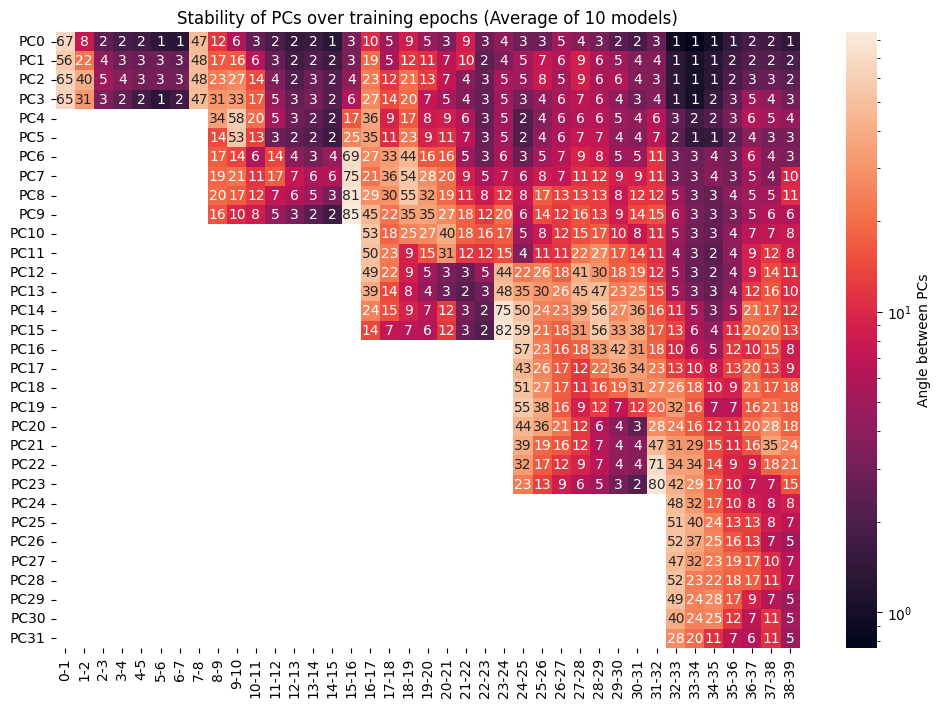

In [21]:
plot_heatmap(average_angle_between_pcs(list_of_dictionaries), all_epoch_pairs, 'average')